## Projeto

In [12]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange

In [13]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [14]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


### SVMs

#### Data preprocessing 

In [15]:
data_frame_fcnc_pca = data_frame_fcnc.copy()
data_frame_bkg_pca = data_frame_bkg.copy()

# Drop the categorical features except label, weights and gen_split
data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

# Drop the features that are not in both dataframes
for feature in data_frame_fcnc_pca.columns.values:
    if feature not in data_frame_bkg_pca.columns.values:
        data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

for feature in data_frame_bkg_pca.columns.values:
    if feature not in data_frame_fcnc_pca.columns.values:
        data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
# Join the dataframes
data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

# Substitute the labels "signal" and "bkg" by 1 and 0
data = data.replace(['signal'], 1)
data= data.replace(['bkg'], 0)

#normalize the data except the categorical features and the weights
DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
data [DataFeatures] = (data [DataFeatures] - data [DataFeatures].mean()) / data [DataFeatures].std()


# Split the data into train, validation and test sets for each dataset

# train, test and validation sets
train = data.loc[data['gen_split'] == 'train']
test = data.loc[data['gen_split'] == 'test']
val = data.loc[data['gen_split'] == 'val']


# get 5000 points of each dataset
train_sgn = train.loc[train['gen_label'] == 1].sample(n=5000, random_state=1)
train_bkg = train.loc[train['gen_label'] == 0].sample(n=5000,random_state=1)
# get 10 batches of 500 points of each dataset and join them
x_train_batches = [pd.concat([train_sgn[i*500:(i+1)*500], train_bkg[i*500:(i+1)*500]]) for i in range(10)]
# shuffle each batch
for i in range(10):
    x_train_batches[i] = x_train_batches[i].sample(frac=1, random_state=1)

# get 5000 points of each dataset
test_sgn = test.loc[test['gen_label'] == 1].sample(n=5000, random_state=1)
test_bkg = test.loc[test['gen_label'] == 0].sample(n=5000, random_state=1)
# get 10 batches of 500 points of each dataset and join them
x_test_batches = [pd.concat([test_sgn[i*500:(i+1)*500], test_bkg[i*500:(i+1)*500]]) for i in range(10)]
# shuffle each batch
for i in range(10):
    x_test_batches[i] = x_test_batches[i].sample(frac=1, random_state=1)

# get 5000 points of each dataset
val_sgn = val.loc[val['gen_label'] == 1].sample(n=5000, random_state=1)
val_bkg = val.loc[val['gen_label'] == 0].sample(n=5000, random_state=1)
# get 10 batches of 500 points of each dataset and join them
x_val_batches = [pd.concat([val_sgn[i*500:(i+1)*500], val_bkg[i*500:(i+1)*500]]) for i in range(10)]
# shuffle each batch
for i in range(10):
    x_val_batches[i] = x_val_batches[i].sample(frac=1, random_state=1)
    
    
# get an array with the labels for each set
y_train_batches = [x_train_batches[i][['gen_label']].values.ravel() for i in range(10)]
y_test_batches = [x_test_batches[i][['gen_label']].values.ravel() for i in range(10)]
y_val_batches = [x_val_batches[i][['gen_label']].values.ravel() for i in range(10)]

# get the weights for each dataset
w_train_batches = [x_train_batches[i][['gen_xsec']].values.ravel() for i in range(10)]
w_test_batches = [x_test_batches[i][['gen_xsec']].values.ravel() for i in range(10)]
w_val_batches = [x_val_batches[i][['gen_xsec']].values.ravel() for i in range(10)]

# get an array with the features for each set
x_train_batches = [x_train_batches[i][['MissingET_MET', 'FatJet1_Tau1']].values for i in range(10)]
x_test_batches = [x_test_batches[i][['MissingET_MET', 'FatJet1_Tau1']].values for i in range(10)]
x_val_batches = [x_val_batches[i][['MissingET_MET', 'FatJet1_Tau1']].values for i in range(10)]


In [16]:
# Renormalize weights (for each batch)
for i in range(10):
    w_train_batches[i][y_train_batches[i]==1] = w_train_batches[i][y_train_batches[i]==1] / w_train_batches[i][y_train_batches[i]==1].sum() * w_train_batches[i].shape[0] / 2
    w_train_batches[i][y_train_batches[i]==0] = w_train_batches[i][y_train_batches[i]==0] / w_train_batches[i][y_train_batches[i]==0].sum() * w_train_batches[i].shape[0] / 2
    w_test_batches[i][y_test_batches[i]==1] = w_test_batches[i][y_test_batches[i]==1] / w_test_batches[i][y_test_batches[i]==1].sum() * w_test_batches[i].shape[0] / 2
    w_test_batches[i][y_test_batches[i]==0] = w_test_batches[i][y_test_batches[i]==0] / w_test_batches[i][y_test_batches[i]==0].sum() * w_test_batches[i].shape[0] / 2
    w_val_batches[i][y_val_batches[i]==1] = w_val_batches[i][y_val_batches[i]==1] / w_val_batches[i][y_val_batches[i]==1].sum() * w_val_batches[i].shape[0] / 2
    w_val_batches[i][y_val_batches[i]==0] = w_val_batches[i][y_val_batches[i]==0] / w_val_batches[i][y_val_batches[i]==0].sum() * w_val_batches[i].shape[0] / 2



#### Train, Val, Test

In [17]:
def train_svm (x_train,y_train, w_train):
    clf = svm.SVC(kernel="rbf", probability=True)   
    clf.fit(x_train, y_train,sample_weight=w_train)
    return clf

def val_svm (clf, x_val, y_val, w_val):
    y_pred = clf.predict(x_val)
    y_pred_prob = clf.predict_proba(x_val)[:,1]
    accuracy = accuracy_score(y_val, y_pred, sample_weight=w_val)
    auc = roc_auc_score(y_val, y_pred_prob, sample_weight=w_val)
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob,sample_weight=w_val)
    return accuracy, auc, fpr, tpr, thresholds, y_pred_prob

def test_svm (clf, x_test, y_test, w_test):
    y_pred = clf.predict(x_test)
    y_pred_prob = clf.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
    auc = roc_auc_score(y_test, y_pred_prob, sample_weight=w_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob,sample_weight=w_test)
    return accuracy, auc, fpr, tpr, thresholds, y_pred_prob

In [18]:
### Get the accuracy and auc for each batch
accuracy_val_batches = []
auc_val_batches = []
fpr_val_batches = []
tpr_val_batches = []

accuracy_test_batches = []
auc_test_batches = []
fpr_test_batches = []
tpr_test_batches = []

for i in range (10):
    clf = train_svm(x_train_batches[i],y_train_batches[i], w_train_batches[i])
    accuracy, auc, fpr, tpr, thresholds, y_pred_prob = val_svm(clf, x_val_batches[i], y_val_batches[i], w_val_batches[i])
    print('Batch: {}'.format(i))
    print('Accuracy Val: {}'.format(accuracy))
    print('AUC Val: {}'.format(auc))
    print('')
    accuracy_val_batches.append(accuracy)
    auc_val_batches.append(auc)
    fpr_val_batches.append(fpr)
    tpr_val_batches.append(tpr)
    
    accuracy, auc, fpr, tpr, thresholds, y_pred_prob = test_svm(clf, x_test_batches[i], y_test_batches[i], w_test_batches[i])
    print('Accuracy Test: {}'.format(accuracy))
    print('AUC Test: {}'.format(auc))
    print('')
    accuracy_test_batches.append(accuracy)
    auc_test_batches.append(auc)
    fpr_test_batches.append(fpr)
    tpr_test_batches.append(tpr)
    

Batch: 0
Accuracy Val: 0.5798168125912325
AUC Val: 0.7584843358899733

Accuracy Test: 0.6368670305097911
AUC Test: 0.7270422757101456

Batch: 1
Accuracy Val: 0.7465762758438659
AUC Val: 0.7746980927273245

Accuracy Test: 0.7953644315923686
AUC Test: 0.8649044332628797

Batch: 2
Accuracy Val: 0.7898210190614979
AUC Val: 0.8608761865719402

Accuracy Test: 0.7076860843596886
AUC Test: 0.7647746206281935

Batch: 3
Accuracy Val: 0.7333248273694893
AUC Val: 0.807057164891142

Accuracy Test: 0.730351025333021
AUC Test: 0.8279579780877313

Batch: 4
Accuracy Val: 0.6885034660835377
AUC Val: 0.7361210126533593

Accuracy Test: 0.7634686048122334
AUC Test: 0.8167850657177829

Batch: 5
Accuracy Val: 0.7259212745967136
AUC Val: 0.7587776863216091

Accuracy Test: 0.6638860156172516
AUC Test: 0.7321533754668986

Batch: 6
Accuracy Val: 0.8038274372327692
AUC Val: 0.8787402276102972

Accuracy Test: 0.7583409549767759
AUC Test: 0.8069879366742868

Batch: 7
Accuracy Val: 0.6472451747767489
AUC Val: 0.6973

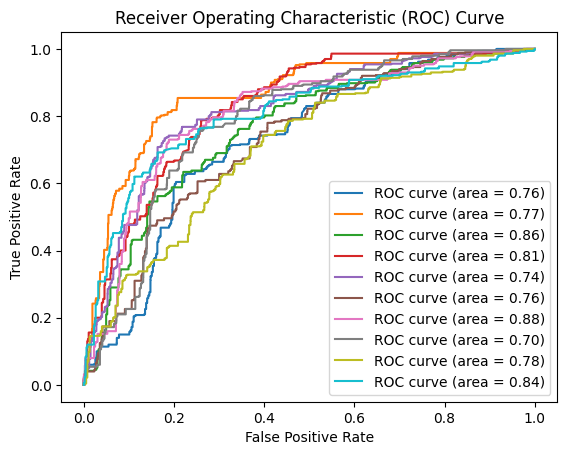

In [19]:
### plot the ROC curve for each batch
for i in range(10):
    # Plot the ROC curve
    plt.plot(fpr_test_batches[i], tpr_test_batches[i], label='ROC curve (area = %0.2f)' % auc_val_batches[i])
 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

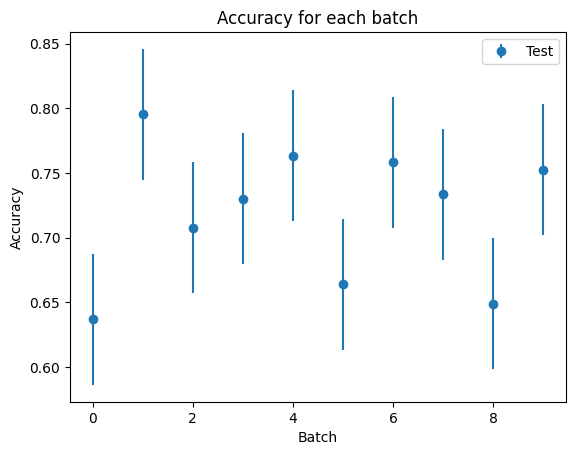

In [20]:
### plot the accuracy for each batch with the error bars
plt.errorbar(range(10), accuracy_test_batches, yerr=np.std(accuracy_test_batches), fmt='o', label='Test')
#plt.errorbar(range(10), accuracy_val_batches, yerr=np.std(accuracy_val_batches), fmt='o', label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.title('Accuracy for each batch')
plt.legend()
plt.show()


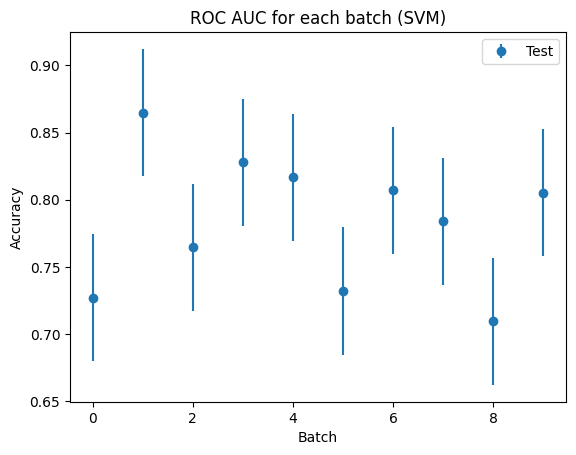

In [21]:
### plot the ROC AUC for each batch with the error bars
plt.errorbar(range(10), auc_test_batches, yerr=np.std(auc_test_batches), fmt='o', label='Test')
#plt.errorbar(range(10), auc_val_batches, yerr=np.std(auc_val_batches), fmt='o', label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.title('ROC AUC for each batch (SVM)')
plt.legend()
plt.show()

In [22]:
a=

SyntaxError: invalid syntax (62411553.py, line 1)

### VQC

#### Pennylane

In [ ]:
data_frame_fcnc_pca = data_frame_fcnc.copy()
data_frame_bkg_pca = data_frame_bkg.copy()

# Drop the categorical features except label, weights and gen_split
data_frame_fcnc_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)
data_frame_bkg_pca.drop(['gen_decay_filter', 'gen_filter', 'gen_n_btags', 'gen_sample', 'gen_sample_filter','gen_decay2','gen_decay1'], axis=1, inplace=True)

# Drop the features that are not in both dataframes
for feature in data_frame_fcnc_pca.columns.values:
    if feature not in data_frame_bkg_pca.columns.values:
        data_frame_fcnc_pca.drop([feature], axis=1, inplace=True)

for feature in data_frame_bkg_pca.columns.values:
    if feature not in data_frame_fcnc_pca.columns.values:
        data_frame_bkg_pca.drop([feature], axis=1, inplace=True)
        
# Join the dataframes
data = pd.concat([data_frame_fcnc_pca, data_frame_bkg_pca])

# Substitute the labels "signal" and "bkg" by 1 and 0
data = data.replace(['signal'], 1)
data= data.replace(['bkg'], 0)

#normalize the data except the categorical features and the weights
DataFeatures = pd.Index(list(set(data.columns) - set(["gen_label", "gen_xsec", "gen_split"])))
data [DataFeatures] = (((data[DataFeatures] - data[DataFeatures].min()) / (data[DataFeatures].max() - data[DataFeatures].min())) * 2 - 1) * (np.pi)


# Split the data into train, validation and test sets for each dataset
# train, test and validation sets
train = data.loc[data['gen_split'] == 'train']
test = data.loc[data['gen_split'] == 'test']
val = data.loc[data['gen_split'] == 'val']


# get 5000 points of each dataset
train_sgn = train.loc[train['gen_label'] == 1].sample(n=5000)
train_bkg = train.loc[train['gen_label'] == 0].sample(n=5000)
# get 10 batches of 500 points of each dataset and join them
x_train_batches = [pd.concat([train_sgn[i*500:(i+1)*500], train_bkg[i*500:(i+1)*500]]) for i in range(10)]
# shuffle each batch
for i in range(10):
    x_train_batches[i] = x_train_batches[i].sample(frac=1)

# get 5000 points of each dataset
test_sgn = test.loc[test['gen_label'] == 1].sample(n=5000)
test_bkg = test.loc[test['gen_label'] == 0].sample(n=5000)
# get 10 batches of 500 points of each dataset and join them
x_test_batches = [pd.concat([test_sgn[i*500:(i+1)*500], test_bkg[i*500:(i+1)*500]]) for i in range(10)]
# shuffle each batch
for i in range(10):
    x_test_batches[i] = x_test_batches[i].sample(frac=1)

# get 5000 points of each dataset
val_sgn = val.loc[val['gen_label'] == 1].sample(n=5000)
val_bkg = val.loc[val['gen_label'] == 0].sample(n=5000)
# get 10 batches of 500 points of each dataset and join them
x_val_batches = [pd.concat([val_sgn[i*500:(i+1)*500], val_bkg[i*500:(i+1)*500]]) for i in range(10)]
# shuffle each batch
for i in range(10):
    x_val_batches[i] = x_val_batches[i].sample(frac=1)
    
    
# get an array with the labels for each set
y_train_batches = [x_train_batches[i][['gen_label']].values.ravel() for i in range(10)]
y_test_batches = [x_test_batches[i][['gen_label']].values.ravel() for i in range(10)]
y_val_batches = [x_val_batches[i][['gen_label']].values.ravel() for i in range(10)]

# get the weights for each dataset
w_train_batches = [x_train_batches[i][['gen_xsec']].values.ravel() for i in range(10)]
w_test_batches = [x_test_batches[i][['gen_xsec']].values.ravel() for i in range(10)]
w_val_batches = [x_val_batches[i][['gen_xsec']].values.ravel() for i in range(10)]

# get an array with the features for each set
x_train_batches = [x_train_batches[i][['MissingET_MET', 'Jet1_BTag']].values for i in range(10)]
x_test_batches = [x_test_batches[i][['MissingET_MET', 'Jet1_BTag']].values for i in range(10)]
x_val_batches = [x_val_batches[i][['MissingET_MET', 'Jet1_BTag']].values for i in range(10)]

# Renormalize weights (for each batch)
for i in range(10):
    w_train_batches[i][y_train_batches[i]==1] = w_train_batches[i][y_train_batches[i]==1] / w_train_batches[i][y_train_batches[i]==1].sum() * w_train_batches[i].shape[0] / 2
    w_train_batches[i][y_train_batches[i]==0] = w_train_batches[i][y_train_batches[i]==0] / w_train_batches[i][y_train_batches[i]==0].sum() * w_train_batches[i].shape[0] / 2
    w_test_batches[i][y_test_batches[i]==1] = w_test_batches[i][y_test_batches[i]==1] / w_test_batches[i][y_test_batches[i]==1].sum() * w_test_batches[i].shape[0] / 2
    w_test_batches[i][y_test_batches[i]==0] = w_test_batches[i][y_test_batches[i]==0] / w_test_batches[i][y_test_batches[i]==0].sum() * w_test_batches[i].shape[0] / 2
    w_val_batches[i][y_val_batches[i]==1] = w_val_batches[i][y_val_batches[i]==1] / w_val_batches[i][y_val_batches[i]==1].sum() * w_val_batches[i].shape[0] / 2
    w_val_batches[i][y_val_batches[i]==0] = w_val_batches[i][y_val_batches[i]==0] / w_val_batches[i][y_val_batches[i]==0].sum() * w_val_batches[i].shape[0] / 2


In [ ]:
# accuracy function
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


In [ ]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# quantum circuit function
def circuit(n_features, n_layers, weights, x):
        # Embedding
        
        qml.AngleEmbedding(x,range (0, n_features),rotation="X" )

        # For every layer
        for layer in range(n_layers):
            W1 = weights[layer]

            # Define Rotations
            for i in range(0,n_features):
                qml.Rot(W1[i, 0], W1[i, 1], W1[i, 2], wires=i)

            # Entanglement
            if n_features != 1:
                if n_features > 2:
                    for i in range(n_features):
                        if i == n_features - 1:
                            qml.CNOT(wires=[i, 0])
                        else:
                            qml.CNOT(wires=[i, i + 1])
                else:
                    qml.CNOT(wires=[1, 0])

        return qml.expval(qml.PauliZ(0))

# classifier function    
def classifier(n_features, n_layers, weights, x):
        #c = circuit(n_features, n_layers, weights, x)
        dev=qml.device("default.qubit", wires=n_features)
        return qml.QNode(circuit, dev)(n_features, n_layers, weights, x)
    
# cost function    
def cost(n_features, n_layers,weights,X,Y,W):  
        # Compute predictions
        y_scores = [(classifier(n_features, n_layers,weights, x) + 1) / 2 for x in X]

        loss = square_loss(Y, y_scores)
        loss = loss * W
        loss = loss.sum()
        
        return loss
    
# train step function    
def train_step(n_features, n_layers,x_train,y_train, w_train, weights, opt,desc='Training'):
        
        # Only require grad if necessary
        x_train = np.array(x_train, requires_grad=False)
        y_train = np.array(y_train, requires_grad=True)
        w_train = np.array(w_train, requires_grad=False)

        # Compute cost and update weights
        weights, loss = opt.step_and_cost(cost, n_features, n_layers,weights, X=x_train, Y=y_train, W=w_train)

        return loss, weights
    
# validation step function
def validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch,best_weights,desc='Validation'):
    X_val = np.array(x_val, requires_grad=False)
    Y_val = np.array(y_val, requires_grad=False)
    W_val = np.array(w_val, requires_grad=False)

    y_scores = np.array([classifier(n_features, n_layers, weights, x) for x in X_val])
    y_scores = (y_scores + 1) / 2

    W_val[Y_val == 1] = (W_val[Y_val == 1] / W_val[Y_val == 1].sum()) * W_val.shape[0] / 2
    W_val[Y_val == 0] = (W_val[Y_val == 0] / W_val[Y_val == 0].sum()) * W_val.shape[0] / 2

    auc_score = roc_auc_score(y_true=Y_val, y_score=y_scores, sample_weight=W_val)
    loss = cost(n_features, n_layers, weights, X_val, Y_val, W_val)


    if best_score is None or auc_score > best_score:
        best_score = auc_score
        best_score_epoch = epoch_number
        best_weights = weights

    tqdm.write(f"Epoch: {epoch_number}, Validation Loss: {loss:.4f}, AUC Score: {auc_score:.4f}")

    return best_score, best_score_epoch, best_weights
        
        
# train function
def train(n_features, n_layers, x_train, y_train,w_train,x_val,y_val,w_val, learning_rate, weights, max_epochs):
    opt = AdamOptimizer(learning_rate)
    best_score = None
    best_weights = None
    best_score_epoch = None
    epoch_number = 0

    with tqdm(total=max_epochs, desc='Epoch', unit='epoch') as pbar:
        for epoch in range(epoch_number, max_epochs):
            epoch_number = epoch

            loss, nf_nl_weights = train_step(n_features, n_layers, x_train, y_train, w_train, weights, opt, desc='Training')
            
            # Log variable values using tqdm.write
            tqdm.write(f"Epoch: {epoch_number:}, Loss: {loss:.4f}")
            
            
            weights = nf_nl_weights[2:]
            weights = weights[0]

            if epoch_number == max_epochs - 1 or (epoch_number+1)%5==0:
                best_score, best_score_epoch, best_weights = validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch, best_weights,desc='Validation')
                # early stopping
                if epoch_number - best_score_epoch > 30 and epoch_number > 80:
                    tqdm.write(f"Early stopping at epoch {epoch_number}")
                    break

            pbar.update(1)  # Update progress bar
        tqdm.write(f"Best Score: {best_score:.4f}")            
        
    return best_score, best_weights


def test(n_features, n_layers,x_test,y_test,w_test, weights):
        # Remove grad
        X_test = np.array(x_test, requires_grad=False)
        Y_test = np.array(y_test, requires_grad=False)
        W_test = np.array(w_test, requires_grad=False)

        # This will be between -1 and 1, we need to convert to between 0 and 1
        y_scores = np.array([classifier(n_features, n_layers,weights, x) for x in X_test])
        y_scores = (y_scores + 1) / 2

        # Renormalize weights
        W_test[Y_test == 1] = (W_test[Y_test == 1] / W_test[Y_test == 1].sum()) * W_test.shape[0] / 2
        W_test[Y_test == 0] = (W_test[Y_test == 0] / W_test[Y_test == 0].sum()) * W_test.shape[0] / 2

        # Calculate ROC
        auc_score = roc_auc_score(y_true=Y_test, y_score=y_scores, sample_weight=W_test)
        
        return auc_score

In [ ]:
# Get the accuracy and auc for each batch
auc_val_batches_vqc = []
auc_test_batches_vqc = []


for i in range (10):
    n_features = 2
    n_layers = 3

    # Random weight initialization
    weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

    # We create a quantum device with n_features "wires" (or qubits)
    dev = qml.device('default.qubit', wires=n_features)

    # train the model
    best_score, best_weights = train (n_features, n_layers,x_train_batches[i],y_train_batches[i],w_train_batches[i],x_val_batches[i],y_val_batches[i],w_train_batches[i],0.01, weights, 1000)
    auc_score_test = test(n_features, n_layers,x_test_batches[i],y_test_batches[i],w_test_batches[i], best_weights)
    auc_score_val = test(n_features, n_layers,x_val_batches[i],y_val_batches[i],w_val_batches[i], best_weights)
    print('Batch: {}'.format(i))
    print('AUC Val: {}'.format(auc_score_val))
    print('AUC Test: {}'.format(auc_score_test))
    print('')
    auc_val_batches_vqc.append(auc_score_val)
    auc_test_batches_vqc.append(auc_score_test)
    


Epoch:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 494.5054
Epoch: 1, Loss: 493.7309
Epoch: 2, Loss: 492.3831
Epoch: 3, Loss: 490.4398
Epoch: 4, Loss: 487.8914
Epoch: 4, Validation Loss: 478.5453, AUC Score: 0.2262
Epoch: 5, Loss: 484.7350


KeyboardInterrupt: 

In [ ]:
### plot the ROC AUC for each batch with the error bars
plt.errorbar(range(10), auc_test_batches_vqc, yerr=np.std(auc_test_batches), fmt='o', label='Test')
#plt.errorbar(range(10), auc_val_batches_vqc, yerr=np.std(auc_val_batches), fmt='o', label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.title('ROC AUC for each batch (VQC)')
plt.legend()
plt.show()